# CH5 Logistic Regression

直接使用Pandas的DataFrame还是很简单的

In [91]:
import numpy as np
import pandas as pd

import progressbar
import logging
progressbar.streams.wrap_stdout()
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - [line:%(lineno)d] - %(levelname)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S')

import warnings
warnings.filterwarnings("ignore")


In [92]:
logging.info("test")

2018-06-24 08:53:00 - [line:1] - INFO: test


In [93]:
df = pd.read_csv("./Data/testSet.txt",sep="\t",header=None)
df.head(2)

,0,1,2
0,-0.017612,14.053064,0
1,-1.395634,4.662541,1


In [94]:
def loadDataSet():
    dataMat = [];labelMat = []
    with open("./Data/testSet.txt") as fr:
        for line in fr.readlines():
            lineArr = line.strip().split()
            dataMat.append([1, float(lineArr[0]), float(lineArr[1])])
            labelMat.append(int(lineArr[2]))
    return dataMat, labelMat    

## MLiA

西瓜书上这样说：
1. 直接对分类的可能进行建模，无需事先假设数据分布，避免了假设分布不准所带来的问题
1. 能拿到近似概率的预测结果
1. 对率函数任意阶可导凸函数，有很好的数学性质

### Sigmoid Function

这个函数有个推导，[李航,2012,P78]
- 有时候为了方便，将权值向量和输入向量加以扩充
$$w=(w^{(1)},w^{(2)},...,w^{(n)},b)^T$$
$$x=(x^{(1)},x^{(2)},...,x^{(n)},1)^T$$

这时LogisticRegression 模型可以表示为
$$P(Y=1\vert x)=\frac{exp(w\cdot x)}{1+exp(w\cdot x)}$$
$$P(Y=0\vert x)=\frac{1}{1+exp(w\cdot x)}$$

用这个去理解“为了计算方便，该函数还将X0的值设为1.0”

还有，李航和MLiA里面讲这里都是在78页。。。。

In [95]:
def sigmoid(inX):
    return 1/(1 + np.exp(-inX))

### Best W

#### GB

In [96]:
def gradAscent(dataMatIn, classLabels):
    dataMatrix = np.mat(dataMatIn)
    labelMatrix = np.mat(classLabels).transpose()
    m,n = np.shape(dataMatrix)
#     print(m,n)
    alpha = 0.001
    maxCycles = 500
    weights = np.ones((n,1))
    for k in list(range(maxCycles)):
        h = sigmoid(dataMatrix*weights)
#         print(np.shape(h))
        error = (labelMatrix - h)
        # return array
#         weights += alpha*dataMatrix.transpose()*error
        # return matrix
        weights = weights + alpha*dataMatrix.transpose()*error
    return weights

In [97]:
dataArr,labelMat = loadDataSet()

In [98]:
wei = gradAscent(dataArr,labelMat)

In [99]:
wei

matrix([[ 4.12414349],
        [ 0.48007329],
        [-0.6168482 ]])

In [100]:
-wei[0,0]/wei[2,0] # 最后可视化的截距

6.685832121185382

绘制决策边界

In [101]:
def plotBestFit(wei):
    import matplotlib.pyplot as plt
    weights = wei if type(wei).__name__ == 'ndarray' else wei.getA()
    dataMat, labelMat = loadDataSet()
    dataArr = np.array(dataMat)
#     print(dataArr)
    n = np.shape(dataArr)[0]
    xcord1 = []; ycord1 = []
    xcord2 = []; ycord2 = []
    for i in range(n):
        if int(labelMat[i]) == 1:
            xcord1.append(dataArr[i,1]); ycord1.append(dataArr[i,2])
        else:
            xcord2.append(dataArr[i,1]);ycord2.append(dataArr[i,2])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1,ycord1,s=30,c="red",marker="s")
    ax.scatter(xcord2,ycord2,s=30,c="green")
    x = np.arange(-3.0, 3.0, 0.1)
#   sigmoid = 0,从图像看 0是分类的分界点
    y = (-weights[0]-weights[1]*x)/weights[2]
    ax.plot(x,y)
    plt.xlabel("X1");plt.ylabel("X2")
    plt.show()

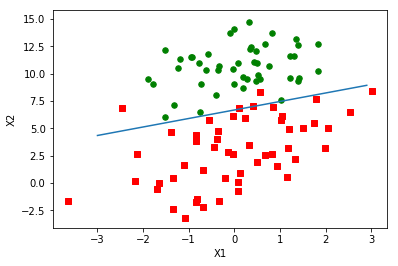

In [102]:
plotBestFit(wei)

#### SGB

In [103]:
def stocGradAscent0(dataMatrix, classLabels):
    m,n = np.shape(dataMatrix)
    alpha = 0.01
    weights = np.ones(n)
    for i in range(m):
        h = sigmoid(sum(dataMatrix[i]*weights))
#         print(np.shape(h))
        error = classLabels[i] - h
        weights = weights + alpha*error*dataMatrix[i]
    return weights

In [104]:
dataArr,labelMat = loadDataSet()
wei = stocGradAscent0(np.array(dataArr),labelMat)
wei

array([ 1.01702007,  0.85914348, -0.36579921])

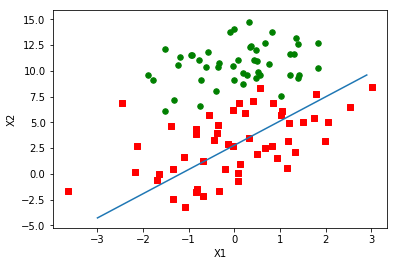

In [105]:
plotBestFit(wei)

In [106]:
def stocGradAscent(dataMatrix, classLabels,numIter = 150):
    m,n = np.shape(dataMatrix)
    alpha = 0.01
    weights = np.ones(n)
    for x in range(numIter):
        for i in range(m):
            h = sigmoid(sum(dataMatrix[i]*weights))
    #         print(np.shape(h))
            error = classLabels[i] - h
            weights = weights + alpha*error*dataMatrix[i]
            if x == 0 and i == 0:
                result = weights
            else:
                result = np.vstack([result,weights])
    return weights,result

###### 迭代过程

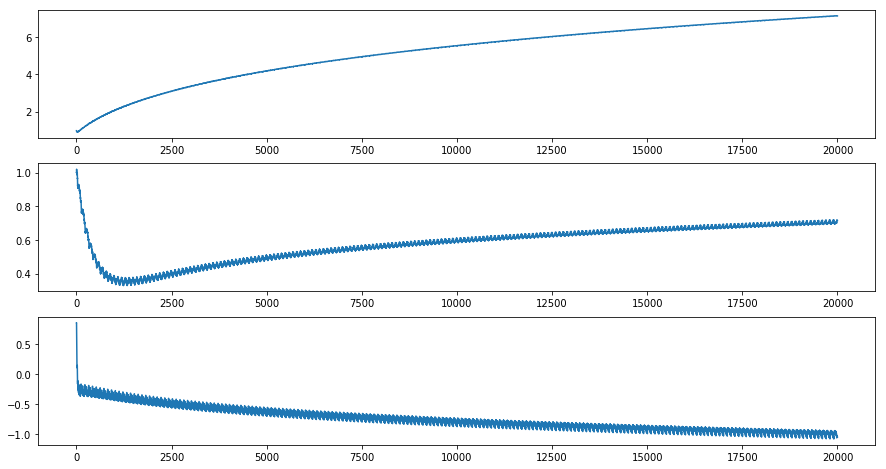

In [107]:
wei,result = stocGradAscent(np.array(dataArr),labelMat,numIter = 200)

x0 = result.transpose()[0]
x1 = result.transpose()[1]
x2 = result.transpose()[2]
y = np.arange(0, len(x0), 1)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

plt.subplot(311)
plt.plot(y,x0)
plt.subplot(312)
plt.plot(y,x1)
plt.subplot(313)
plt.plot(y,x2)
plt.show()

抖动是来自样本之间的差异，数据集并非线性可分

###### 改进

In [108]:
def stocGradAscent1(dataMatrix, classLabels,numIter = 150):
    m,n = np.shape(dataMatrix)
    weights = np.ones(n)
    for i in progressbar.progressbar(range(numIter)):
#         print("Iterations %d" % i)
        dataIndex = list(range(m))
        for j in range(m):
            alpha = 4/(1 + j + i) + 0.01
            randIndex = int(np.random.uniform(0,len(dataIndex)))            
            h = sigmoid(sum(dataMatrix[randIndex]*weights))
            error = classLabels[randIndex] - h
            weights = weights + alpha*error*dataMatrix[randIndex]
            del(dataIndex[randIndex])
            if i == 0 and j == 0:
                result = weights
            else:
                result = np.vstack([result,weights])
    return weights,result

100% (40 of 40) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


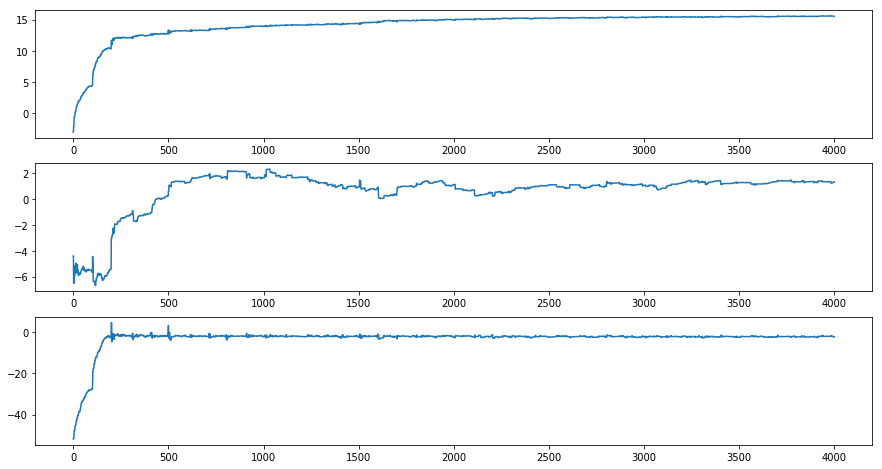

In [109]:
wei,result = stocGradAscent1(np.array(dataArr),labelMat,numIter = 40)

x0 = result.transpose()[0]
x1 = result.transpose()[1]
x2 = result.transpose()[2]
y = np.arange(0,len(x0), 1)
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

plt.subplot(311)
plt.plot(y,x0)
plt.subplot(312)
plt.plot(y,x1)
plt.subplot(313)
plt.plot(y,x2)
plt.show()

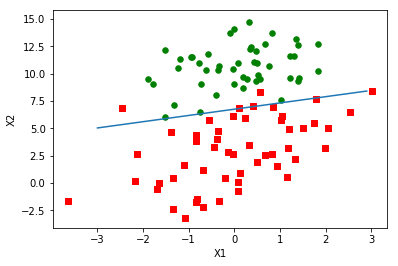

In [110]:
plotBestFit(wei)

### EX : Horse Colic

#### by np

In [111]:
def classifyVector(inX,weights):
    prob = sigmoid(sum(inX*weights))
    if prob > 0.5: return 1
    else: return 0

In [112]:
def colicTest():
    frTrain = open("./Data/CH5/horseColicTraining.txt")
    frTest = open("./Data/CH5/horseColicTest.txt")
    trainingSet = []; trainingLabels = []
    for line in frTrain.readlines():
        currLine = line.strip().split("\t")
        lineArr = []
        for i in range(21):
            lineArr.append(float(currLine[i]))
        trainingSet.append(lineArr)
        trainingLabels.append(float(currLine[21]))

    trainWeights, results = stocGradAscent1(np.array(trainingSet),trainingLabels,numIter = 50)
    errorCount = 0; numTestVec = 0
    for line in frTest.readlines():
        numTestVec += 1
        currLine = line.strip().split("\t")
        lineArr = []
        for i in range(21):
            lineArr.append(float(currLine[i]))
        if int(classifyVector(np.array(lineArr),trainWeights)) != int(currLine[21]):
            errorCount += 1
    errorRate = errorCount/numTestVec
    logging.info("the error rate of this test is: %f" , errorRate)
    return errorRate

In [113]:
def multiTest():
    numTests = 5; errorSum=0
    for k in range(numTests):
        errorSum +=colicTest()
    logging.info("after %d iterations the average error rate is: %f", numTests, errorSum/numTests)

In [114]:
logging.info("")

2018-06-24 08:53:03 - [line:1] - INFO: 


In [115]:
multiTest()

100% (50 of 50) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
2018-06-24 08:53:14 - [line:24] - INFO: the error rate of this test is: 0.447761
100% (50 of 50) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
2018-06-24 08:53:25 - [line:24] - INFO: the error rate of this test is: 0.537313
100% (50 of 50) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
2018-06-24 08:53:35 - [line:24] - INFO: the error rate of this test is: 0.343284
100% (50 of 50) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
2018-06-24 08:53:46 - [line:24] - INFO: the error rate of this test is: 0.417910
100% (50 of 50) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
2018-06-24 08:53:57 - [line:24] - INFO: the error rate of this test is: 0.343284
2018-06-24 08:53:57 - [line:5] - INFO: after 5 iterations the average error rate is: 0.417910


#### by pd

In [116]:
import pandas as pd

In [117]:
train_df = pd.read_table("./Data/CH5/horseColicTraining.txt",header=None)
test_df = pd.read_table("./Data/CH5/horseColicTest.txt",header=None)

In [118]:
train_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,2.0,1.0,38.5,66.0,28.0,3.0,3.0,0.0,2.0,5.0,...,0.0,0.0,0.0,3.0,5.0,45.0,8.4,0.0,0.0,0.0
1,1.0,1.0,39.2,88.0,20.0,0.0,0.0,4.0,1.0,3.0,...,0.0,0.0,0.0,4.0,2.0,50.0,85.0,2.0,2.0,0.0


In [119]:
test_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,2,1,38.5,54,20,0,1,2,2,3,...,2,2,5.9,0,2,42.0,6.3,0,0.0,1
1,2,1,37.6,48,36,0,0,1,1,0,...,0,0,0.0,0,0,44.0,6.3,1,5.0,1


In [120]:
def colicTest_df():
    train_df = pd.read_table("./Data/CH5/horseColicTraining.txt",header=None)
    test_df = pd.read_table("./Data/CH5/horseColicTest.txt",header=None)
    trainingSet = train_df[list(range(21))].values
    trainingLabels = train_df[[21]].values
    trainWeights, results = stocGradAscent1(trainingSet,trainingLabels,numIter = 50)
    errorCount = 0; numTestVec = 0
    testSet = test_df[list(range(21))].values
    testLabels = test_df[[21]].values.reshape(-1)
    errorRate = sum(sigmoid(sum((testSet*trainWeights).T)).astype("int32") != testLabels)/len(testLabels)
    logging.info("the error rate of this test is: %f" , errorRate)
    return errorRate

In [121]:
colicTest_df()

100% (50 of 50) |########################| Elapsed Time: 0:00:11 Time:  0:00:11
2018-06-24 08:54:08 - [line:11] - INFO: the error rate of this test is: 0.447761


0.44776119402985076

In [122]:
def multiTest_df():
    numTests = 5; errorSum=0
    for k in range(numTests):
        errorSum +=colicTest_df()
    logging.info("after %d iterations the average error rate is: %f", numTests, errorSum/numTests)

In [123]:
multiTest_df()

100% (50 of 50) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
2018-06-24 08:54:19 - [line:11] - INFO: the error rate of this test is: 0.492537
100% (50 of 50) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
2018-06-24 08:54:29 - [line:11] - INFO: the error rate of this test is: 0.402985
100% (50 of 50) |########################| Elapsed Time: 0:00:11 Time:  0:00:11
2018-06-24 08:54:41 - [line:11] - INFO: the error rate of this test is: 0.492537
100% (50 of 50) |########################| Elapsed Time: 0:00:10 Time:  0:00:10
2018-06-24 08:54:51 - [line:11] - INFO: the error rate of this test is: 0.552239
100% (50 of 50) |########################| Elapsed Time: 0:00:11 Time:  0:00:11
2018-06-24 08:55:03 - [line:11] - INFO: the error rate of this test is: 0.567164
2018-06-24 08:55:03 - [line:5] - INFO: after 5 iterations the average error rate is: 0.501493


## Sklearn

### Load Data

In [124]:
def loadDataSet():
    dataMat = [];labelMat = []
    with open("./Data/testSet.txt") as fr:
        for line in fr.readlines():
            lineArr = line.strip().split()
            dataMat.append([1, float(lineArr[0]), float(lineArr[1])])
            labelMat.append(int(lineArr[2]))
    return dataMat, labelMat    

In [125]:
dataMat, labelMat = loadDataSet()

In [126]:
X = np.array(dataMat)
y = np.array(labelMat)

### GD

#### Modeling

In [127]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [128]:
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [129]:
lr.coef_

array([[ 2.45317293,  0.51690909, -0.71377635]])

In [130]:
lr.intercept_

array([2.45317293])

#### Decision Boundary

In [131]:
# for line
clf_x = np.arange(-4,4.1,0.1)
clf_y = (-lr.coef_[0][0]-lr.coef_[0][1]*clf_x - lr.intercept_)/lr.coef_[0][2]
Class1 = X[[np.where(y==1)],1:][0][0]
Class0 = X[[np.where(y==0)],1:][0][0]
Class1[:,1]

array([ 4.662541,  7.067335,  6.866805,  6.920334,  3.16702 ,  5.749003,
        1.589505,  6.151823,  2.690988,  0.444165,  5.754399,  3.230619,
       -0.55754 , -1.67873 ,  2.672471, -1.618087,  3.523953,  3.989286,
        8.294984, -2.406051,  4.951851,  3.297303,  6.105155,  0.548467,
        2.676045, -2.166125,  5.921938,  5.027866,  6.835839,  7.718645,
        4.7473  ,  4.119083,  1.960539, -1.466018,  6.476801,  0.468339,
        2.874846, -0.027255,  2.171228,  5.019981,  4.375691, -3.181888,
        8.401766,  1.688274, -1.733869,  3.849075,  5.468166,  0.059736,
       -0.7153  ,  0.922311,  1.22053 ,  2.556666,  0.143632])

In [132]:
#  np.c_ np.r_ 矩阵拼接
# np.c_[np.ones(xx.ravel().shape),xx.ravel(), yy.ravel()]

In [133]:
# for decision boundary
xx, yy = np.meshgrid(np.arange(-4, 4.1, 0.1), np.arange(-5, 20, 0.1))
Z = lr.predict(np.c_[np.ones(xx.ravel().shape),xx.ravel(), yy.ravel()])

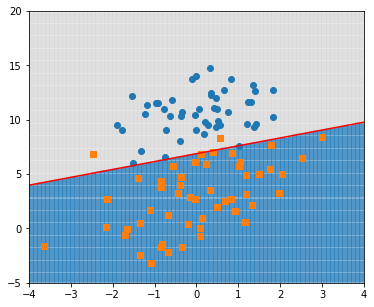

In [134]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))

Z = Z.reshape(xx.shape)
# for line
# plt.contour(xx,yy,Z)
plt.plot(clf_x,clf_y,c="r")
# for mesh
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Vega20c_r, alpha=0.6)
# for data
plt.scatter(x=Class0[:,0],y=Class0[:,1])
plt.scatter(x=Class1[:,0],y=Class1[:,1],marker="s")
plt.ylim(-5,20)
plt.xlim(-4,4)
plt.show()

### SGD

#### Modeling

In [135]:
from sklearn.linear_model import SGDClassifier

In [136]:
# SGD_clf = SGDClassifier()
SGD_clf = SGDClassifier(max_iter=50)


In [137]:
SGD_clf.fit(X,y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=50, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [138]:
SGD_clf.coef_

array([[ 85.01416903,  31.98983997, -51.43373729]])

In [139]:
SGD_clf.intercept_

array([345.08727735])

#### Decision Boundary

In [140]:
# for line
clf_x = np.arange(-4,4.1,0.1)
clf_y = (-SGD_clf.coef_[0][0]-SGD_clf.coef_[0][1]*clf_x - SGD_clf.intercept_)/SGD_clf.coef_[0][2]
Class1 = X[[np.where(y==1)],1:][0][0]
Class0 = X[[np.where(y==0)],1:][0][0]
Class1[:,1]

array([ 4.662541,  7.067335,  6.866805,  6.920334,  3.16702 ,  5.749003,
        1.589505,  6.151823,  2.690988,  0.444165,  5.754399,  3.230619,
       -0.55754 , -1.67873 ,  2.672471, -1.618087,  3.523953,  3.989286,
        8.294984, -2.406051,  4.951851,  3.297303,  6.105155,  0.548467,
        2.676045, -2.166125,  5.921938,  5.027866,  6.835839,  7.718645,
        4.7473  ,  4.119083,  1.960539, -1.466018,  6.476801,  0.468339,
        2.874846, -0.027255,  2.171228,  5.019981,  4.375691, -3.181888,
        8.401766,  1.688274, -1.733869,  3.849075,  5.468166,  0.059736,
       -0.7153  ,  0.922311,  1.22053 ,  2.556666,  0.143632])

In [141]:
# for decision boundary
xx, yy = np.meshgrid(np.arange(-4, 4.1, 0.1), np.arange(-5, 20, 0.1))
Z = SGD_clf.predict(np.c_[np.ones(xx.ravel().shape),xx.ravel(), yy.ravel()])

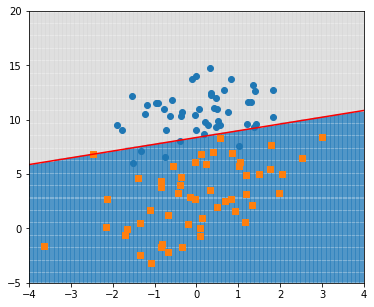

In [142]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))

Z = Z.reshape(xx.shape)
# for line
# plt.contour(xx,yy,Z)
plt.plot(clf_x,clf_y,c="r")
# for mesh
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Vega20c_r, alpha=0.6)
# for data
plt.scatter(x=Class0[:,0],y=Class0[:,1])
plt.scatter(x=Class1[:,0],y=Class1[:,1],marker="s")
plt.ylim(-5,20)
plt.xlim(-4,4)
plt.show()

以上，
- 参数默认，效果不如GD,每次的效果随机，因为默认的max_iter_是5(v0.19)，0.21将默认1000
- 调整max_iter就收敛了
- 或者调整tol=1e-8一样会收敛
- learning_rate可以选optimal，这样会是变系数的类似改进SGD

### EX : Horse Colic 

#### Load Data

In [143]:
train_df = pd.read_table("./Data/CH5/horseColicTraining.txt",header=None)
train_df.head()


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,2.0,1.0,38.5,66.0,28.0,3.0,3.0,0.0,2.0,5.0,...,0.0,0.0,0.0,3.0,5.0,45.0,8.4,0.0,0.0,0.0
1,1.0,1.0,39.2,88.0,20.0,0.0,0.0,4.0,1.0,3.0,...,0.0,0.0,0.0,4.0,2.0,50.0,85.0,2.0,2.0,0.0
2,2.0,1.0,38.3,40.0,24.0,1.0,1.0,3.0,1.0,3.0,...,0.0,0.0,0.0,1.0,1.0,33.0,6.7,0.0,0.0,1.0
3,1.0,9.0,39.1,164.0,84.0,4.0,1.0,6.0,2.0,2.0,...,1.0,2.0,5.0,3.0,0.0,48.0,7.2,3.0,5.3,0.0
4,2.0,1.0,37.3,104.0,35.0,0.0,0.0,6.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,74.0,7.4,0.0,0.0,0.0


In [144]:
test_df = pd.read_table("./Data/CH5/horseColicTest.txt",header=None)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,2,1,38.5,54,20,0,1,2,2,3,...,2,2,5.9,0,2,42.0,6.3,0,0.0,1
1,2,1,37.6,48,36,0,0,1,1,0,...,0,0,0.0,0,0,44.0,6.3,1,5.0,1
2,1,1,37.7,44,28,0,4,3,2,5,...,1,1,0.0,3,5,45.0,70.0,3,2.0,1
3,1,1,37.0,56,24,3,1,4,2,4,...,1,1,0.0,0,0,35.0,61.0,3,2.0,0
4,2,1,38.0,42,12,3,0,3,1,1,...,0,0,0.0,0,2,37.0,5.8,0,0.0,1


In [145]:
X_train = train_df.values[:,:20]

In [146]:
y_train = train_df.values[:,-1]

#### Modeling

In [147]:
from sklearn.linear_model import SGDClassifier
SGD_clf = SGDClassifier(loss = "log",max_iter=50,random_state=2018)

In [148]:
SGD_clf.fit(X_train,y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=50, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=2018,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [149]:
X_test = test_df.values[:,:20]

In [150]:
y_test = test_df.values[:,-1]

In [151]:
y_pred = SGD_clf.predict(X_test)

In [152]:
print("error rate is %1.2f" % (100*np.mean(y_test==y_pred)))

In [153]:
np.mean(y_test==y_pred)

0.7164179104477612

In [154]:
y_test.shape

(67,)

In [155]:
SGD_clf.coef_

array([[ 381.46407344,   53.87496098,  103.85488041,  -42.75562163,
          74.58070964, -167.59856095, -113.06092488, -494.82865602,
          -2.12150406, -314.25609958,  340.89460268, -138.74972483,
         456.14132845,  -93.39288322, -167.04011532,  232.73237231,
        -153.11825359,  -21.64036846,   31.71965708, -195.16459814]])

以上
- 固定随机种子，结果会不变
- 不固定，变化范围不小
- 20维数据，不好像之前的数据那样可视化决策边界
- 参考[sklearn文档](http://scikit-learn.org/stable/modules/sgd.html#sgd)SGD对输入数据敏感

#### Tuning

In [158]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [159]:
sss = StandardScaler()
mms = MinMaxScaler()

In [160]:
train_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
count,299.000000,299.00000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,...,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,1.397993,1.64214,30.509365,66.220736,24.551839,1.906355,1.555184,2.404682,1.167224,2.404682,...,1.143813,1.023411,0.834448,1.816054,2.230769,41.816054,21.595318,0.913043,1.026756,0.595318
std,0.490305,2.17730,15.326224,33.741787,19.922496,1.315088,1.250288,1.817175,0.606560,1.644631,...,0.987873,0.998045,1.982029,1.657688,2.144978,16.934178,26.905928,1.149466,1.836639,0.491653
min,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.00000,37.200000,48.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,6.200000,0.000000,0.000000,0.000000
50%,1.000000,1.00000,38.000000,60.000000,22.000000,2.000000,1.000000,2.000000,1.000000,2.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,44.000000,7.200000,0.000000,0.000000,1.000000
75%,2.000000,1.00000,38.500000,88.000000,34.500000,3.000000,3.000000,4.000000,2.000000,4.000000,...,2.000000,1.000000,0.000000,4.000000,5.000000,50.000000,52.000000,2.000000,2.000000,1.000000
max,2.000000,9.00000,40.800000,184.000000,96.000000,4.000000,4.000000,6.000000,3.000000,5.000000,...,3.000000,3.000000,7.500000,4.000000,5.000000,75.000000,89.000000,3.000000,10.100000,1.000000


In [161]:
test_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,...,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,1.492537,1.477612,32.894030,63.970149,24.835821,2.104478,1.373134,2.701493,1.164179,2.417910,...,1.014925,1.059701,1.386567,1.805970,2.373134,38.304478,22.695522,1.208955,1.255224,0.701493
std,0.503718,1.909769,13.067805,27.570279,20.322101,1.244799,1.191330,1.517723,0.566676,1.509056,...,0.961258,1.071399,2.652837,1.707726,2.102205,17.627608,28.364507,1.200219,1.822193,0.461057
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,37.500000,44.500000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,35.000000,5.850000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,38.000000,60.000000,20.000000,2.000000,1.000000,3.000000,1.000000,2.000000,...,1.000000,1.000000,0.000000,1.000000,3.000000,41.000000,6.800000,1.000000,0.000000,1.000000
75%,2.000000,1.000000,38.300000,80.000000,36.000000,3.000000,2.500000,3.000000,1.500000,3.000000,...,2.000000,2.000000,0.000000,4.000000,4.000000,47.000000,56.000000,2.000000,2.000000,1.000000
max,2.000000,9.000000,39.700000,150.000000,96.000000,4.000000,4.000000,6.000000,2.000000,5.000000,...,3.000000,3.000000,8.500000,4.000000,5.000000,74.000000,79.000000,3.000000,8.000000,1.000000


In [162]:
all_data = pd.concat([train_df,test_df],ignore_index=True).reindex()

In [163]:
all_data.columns.tolist()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

In [164]:
for idx in all_data.columns.tolist()[:-1]:
    all_data[[idx]] = mms.fit_transform(all_data[[idx]].values)

In [165]:
X_train = all_data[:train_df.shape[0]].values[:,:-1]
X_train.shape

(299, 21)

In [166]:
y_train =  all_data[:train_df.shape[0]].values[:,-1]

In [167]:
X_test = all_data[train_df.shape[0]:].values[:,:-1]

In [168]:
y_test =  all_data[train_df.shape[0]:].values[:,-1]

In [169]:
X_test

array([[1.        , 0.        , 0.94362745, ..., 0.07078652, 0.        ,
        0.        ],
       [1.        , 0.        , 0.92156863, ..., 0.07078652, 0.33333333,
        0.4950495 ],
       [0.        , 0.        , 0.92401961, ..., 0.78651685, 1.        ,
        0.1980198 ],
       ...,
       [0.        , 0.        , 0.93137255, ..., 0.73033708, 1.        ,
        0.1980198 ],
       [1.        , 0.        , 0.93137255, ..., 0.06516854, 0.        ,
        0.        ],
       [1.        , 0.        , 0.92156863, ..., 0.06741573, 0.        ,
        0.        ]])

In [170]:
SGD_clf = SGDClassifier(loss = "log",max_iter=1500,random_state=2018)

In [171]:
SGD_clf.fit(X_train,y_train)
y_pred = SGD_clf.predict(X_test)

In [172]:
np.mean(y_pred==y_test)

0.7313432835820896

- 用了没有处理之前的模型参数，只处理数据，居然变差了...
- 改变迭代次数，正确率能提升
- 用mms和sss差别不大

TODO:
1. 用原始数据集，数据处理也做一下
1. 考虑数据可视化，分析下